In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline

In [2]:
df = pd.read_csv("alipaga_dataset.csv", encoding = "ISO-8859-1")

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,...,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [4]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


Pré-processamento

In [5]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Postal Code', 'Market', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping Cost', 'Order Priority'],
      dtype='object')

In [6]:
print(*df.columns) 

Row ID Order ID Order Date Ship Date Ship Mode Customer ID Customer Name Segment City State Country Postal Code Market Region Product ID Category Sub-Category Product Name Sales Quantity Discount Profit Shipping Cost Order Priority


In [7]:
df.rename(columns = lambda x: x.lower().replace(' ', '_').replace('-', '_'), inplace=True)

In [8]:
print(*df.columns) 

row_id order_id order_date ship_date ship_mode customer_id customer_name segment city state country postal_code market region product_id category sub_category product_name sales quantity discount profit shipping_cost order_priority


In [9]:
df.isna().any().any()

True

In [10]:
df.loc[:, df.isnull().any()].columns

Index(['postal_code'], dtype='object')

In [11]:
df['order_date'] = pd.to_datetime(df.order_date)


In [12]:
df = df.drop(columns=["postal_code"])

In [13]:
al_ = np.unique(df["order_priority"])
prior ={'Critical':3, 'High':2, 'Medium':1, 'Low': 0}
df["order_priority"] = df["order_priority"].apply(lambda x: prior[x])

In [14]:
df["order_priority"].head()

0    1
1    1
2    2
3    2
4    1
Name: order_priority, dtype: int64

In [15]:
sales_day = df.groupby(["order_date"]).sales.sum().reset_index()
sales_month = sales_day.groupby(pd.Grouper(key='order_date', freq='M')).sum().reset_index()

In [16]:
sales_day

,order_date,sales
0,2011-01-01,808.56300
1,2011-01-02,2455.67000
2,2011-01-03,12565.76630
3,2011-01-04,2582.80100
4,2011-01-06,11480.49270
...,...,...
1425,2014-12-27,13421.26376
1426,2014-12-28,1647.17400
1427,2014-12-29,25109.28878
1428,2014-12-30,16831.61480


In [17]:
sales_month = sales_day.groupby(pd.Grouper(key='order_date', freq='M')).sum().reset_index()

In [18]:
sales_month["order_date"] = sales_month['order_date'].apply(lambda x: x.strftime('%Y-%m'))

### Total de Vendas por Mês/Ano

In [19]:
sales_month

,order_date,sales
0,2011-01,138241.30042
1,2011-02,134969.94086
2,2011-03,171455.59372
3,2011-04,128833.47034
4,2011-05,148146.72092
5,2011-06,189338.43966
6,2011-07,162034.69756
7,2011-08,219223.49524
8,2011-09,255237.89698
9,2011-10,204675.07846


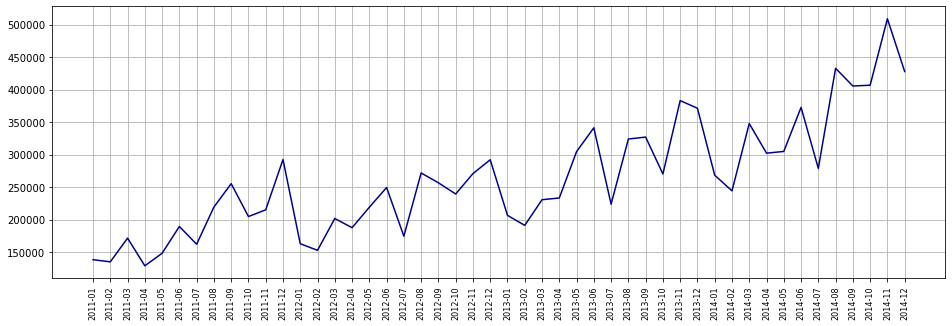

In [20]:
plt.figure(figsize=(16, 5))
plt.plot(sales_month['order_date'], sales_month['sales'], color='darkblue')
plt.xticks(rotation='vertical', size=8)
plt.grid()
plt.show()

### Produtos que arrecadaram mais valor

In [21]:
prod_ = df.groupby('product_name').sum()['sales'].to_frame()
prod_.sort_values(by=['sales'], inplace=True, ascending=False)

prod_[:10]

,sales
product_name,
"Apple Smart Phone, Full Size",86935.7786
"Cisco Smart Phone, Full Size",76441.5306
"Motorola Smart Phone, Full Size",73156.3030
"Nokia Smart Phone, Full Size",71904.5555
Canon imageCLASS 2200 Advanced Copier,61599.8240
"Hon Executive Leather Armchair, Adjustable",58193.4841
"Office Star Executive Leather Armchair, Adjustable",50661.6840
"Harbour Creations Executive Leather Armchair, Adjustable",50121.5160
"Samsung Smart Phone, Cordless",48653.4600


In [22]:
print("Principais produtos vendidos:\n", prod_.head(10))

Principais produtos vendidos:
                                                          sales
product_name                                                  
Apple Smart Phone, Full Size                        86935.7786
Cisco Smart Phone, Full Size                        76441.5306
Motorola Smart Phone, Full Size                     73156.3030
Nokia Smart Phone, Full Size                        71904.5555
Canon imageCLASS 2200 Advanced Copier               61599.8240
Hon Executive Leather Armchair, Adjustable          58193.4841
Office Star Executive Leather Armchair, Adjustable  50661.6840
Harbour Creations Executive Leather Armchair, A...  50121.5160
Samsung Smart Phone, Cordless                       48653.4600
Nokia Smart Phone, with Caller ID                   47877.7857


In [23]:
df.groupby('order_date')['product_name','sales'].apply(lambda x: x.mode().iloc[0]).reset_index()

<ipython-input-23-99d4664e646f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('order_date')['product_name','sales'].apply(lambda x: x.mode().iloc[0]).reset_index()


,order_date,product_name,sales
0,2011-01-01,"Acme Trimmer, High Speed",44.865
1,2011-01-02,"Acco Hole Reinforcements, Recycled",9.576
2,2011-01-03,"Acco 3-Hole Punch, Recycled",5.940
3,2011-01-04,"Apple Signal Booster, Full Size",6.240
4,2011-01-06,3M Hangers With Command Adhesive,6.990
...,...,...,...
1425,2014-12-27,Acco Economy Flexible Poly Round Ring Binder,3.132
1426,2014-12-28,AT&T 1080 Corded phone,8.760
1427,2014-12-29,3M Hangers With Command Adhesive,1.188
1428,2014-12-30,"Dania Stackable Bookrack, Pine",44.640


### Quantos dos clientes utilizaram descontos?

In [49]:
f_t = (df['discount'] > 0).value_counts()

In [52]:
max = f_t[0] + f_t[1]

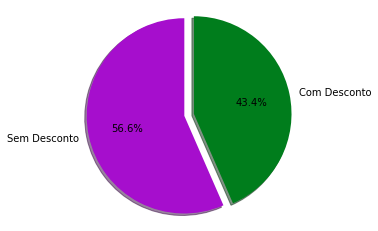

In [59]:
labels = 'Sem Desconto', 'Com Desconto'
sizes = [f_t[0]/100 , f_t[1]/100]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ["#A60ECD","#007D1C"]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=colors, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Quais foram os produtos que mais obtiveram descontos

In [67]:
discount = df.groupby(df["product_name"]).discount.sum().reset_index()
discount.sort_values(by=['discount'], inplace=True, ascending=False)
discount.head(10)

,product_name,discount
3275,Staples,21.20
2840,"Rogers File Cart, Single Width",16.26
3179,"Smead File Cart, Single Width",13.06
3194,"Smead Lockers, Single Width",11.21
3354,"Stockwell Thumb Tacks, Metal",10.75
1981,"Ibico Index Tab, Clear",10.71
3070,"Sanford Pencil Sharpener, Water Color",10.66
894,"Cardinal Index Tab, Clear",10.32
3335,"Stockwell Paper Clips, Assorted Sizes",9.86
3400,"Tenex File Cart, Single Width",9.71


### Métodos de envio preferidos


In [86]:
df["ship_mode"].value_counts()

Standard Class    30775
Second Class      10309
First Class        7505
Same Day           2701
Name: ship_mode, dtype: int64

In [69]:
columns = df[["row_id","sales","country","profit"]]
df_sales = columns.copy()

In [70]:
df_sales

,row_id,sales,country,profit
0,42433,408.300,Algeria,106.1400
1,22253,120.366,Australia,36.0360
2,48883,66.120,Hungary,29.6400
3,11731,44.865,Sweden,-26.0550
4,22255,113.670,Australia,37.7700
...,...,...,...,...
51285,32593,13.904,United States,4.5188
51286,47594,3.990,Morocco,0.4200
51287,8857,26.400,Nicaragua,12.3600
51288,6852,7.120,Mexico,0.5600


In [71]:
n_paises = len(np.unique(df_sales["country"]))

In [72]:
dff = df_sales.groupby(["country"]).sales.sum().reset_index()

In [73]:
dff.sort_values(by=["sales"], ascending=False)

,country,sales
139,United States,2.297201e+06
6,Australia,9.252359e+05
44,France,8.589311e+05
26,China,7.005620e+05
47,Germany,6.288400e+05
...,...,...
127,Tajikistan,2.427840e+02
75,Macedonia,2.096400e+02
40,Eritrea,1.877400e+02
5,Armenia,1.567500e+02


In [74]:
import matplotlib.style as style
dims = (30, 20)
#style.available


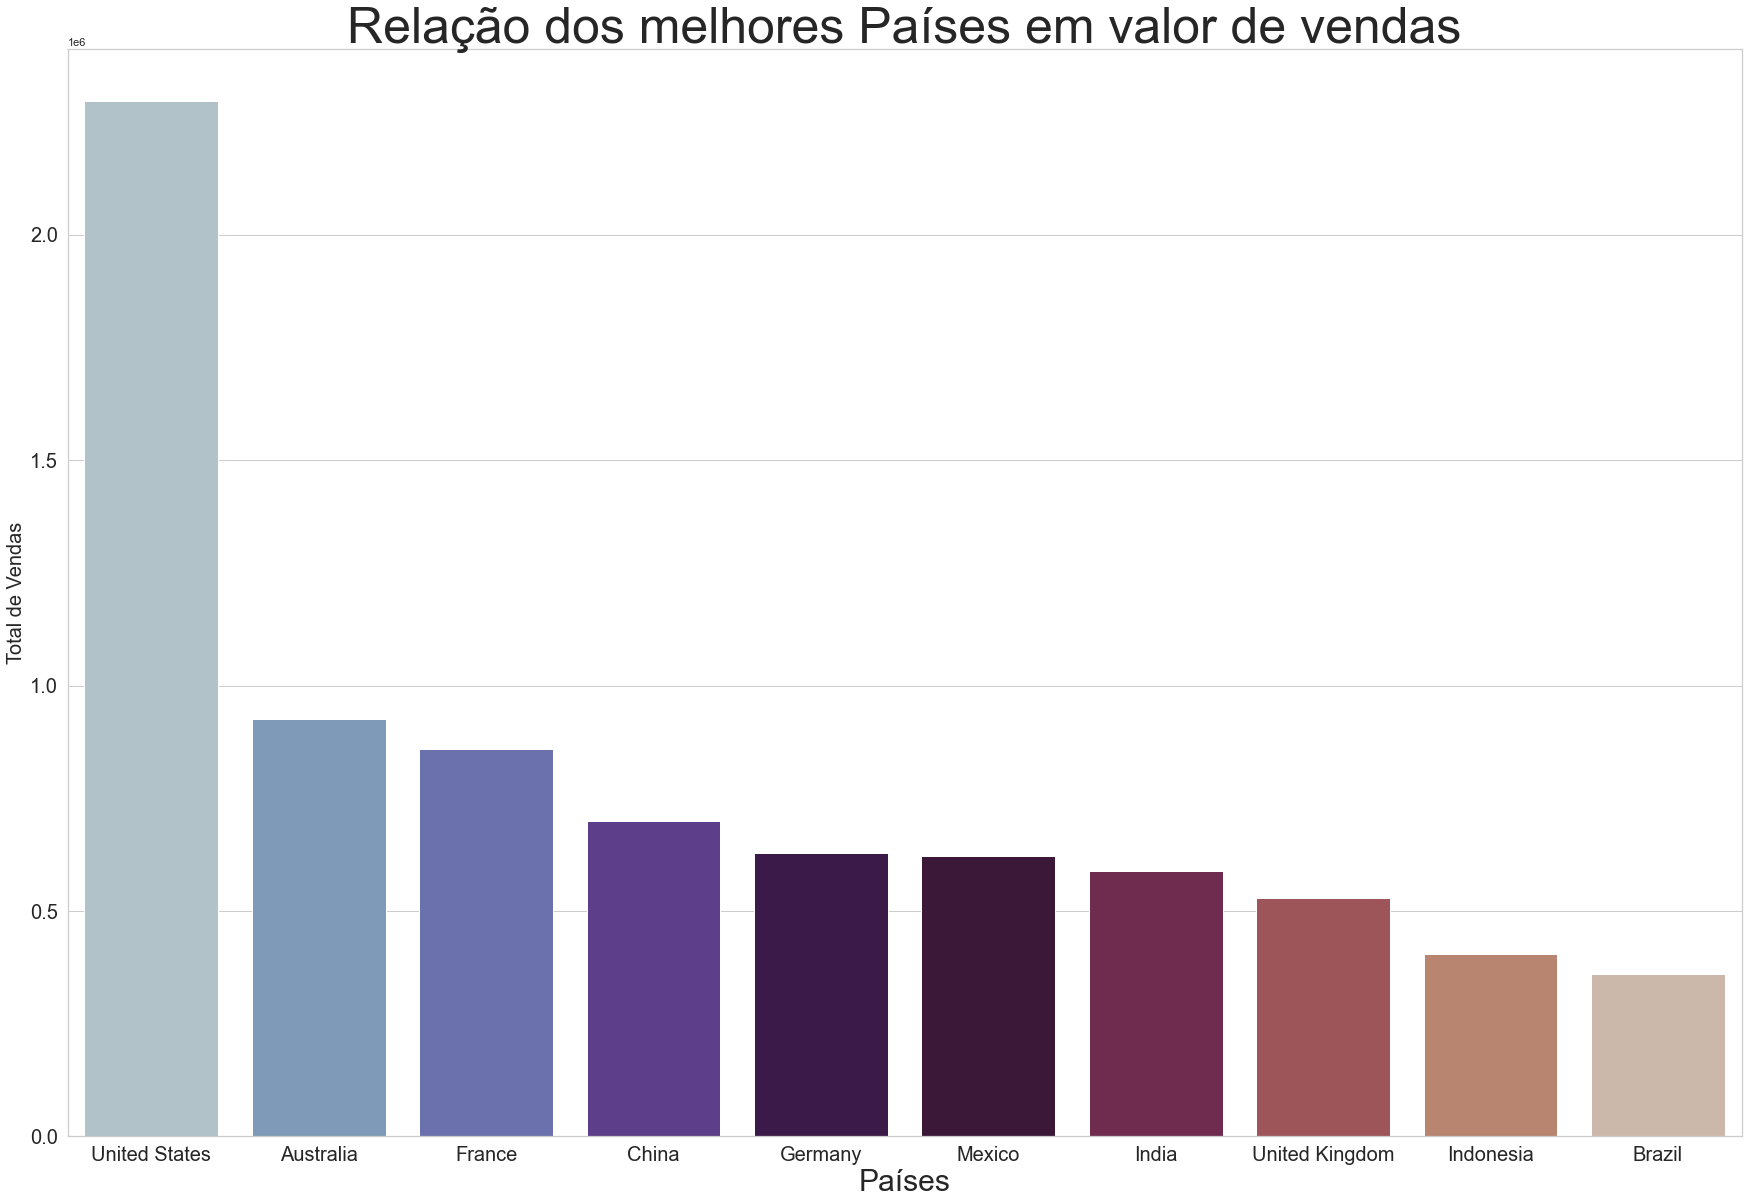

In [75]:
sns.set_theme(style="whitegrid")
ax = plt.subplots(figsize=dims)

b = sns.barplot(x="country", y="sales", data=dff.sort_values(by=["sales"], ascending=False).head(10), palette=("twilight"))
b.axes.set_title("Relação dos melhores Países em valor de vendas",fontsize=50)
b.set_xlabel("Países",fontsize=30)
b.set_ylabel("Total de Vendas",fontsize=20)
b.tick_params(labelsize=20)

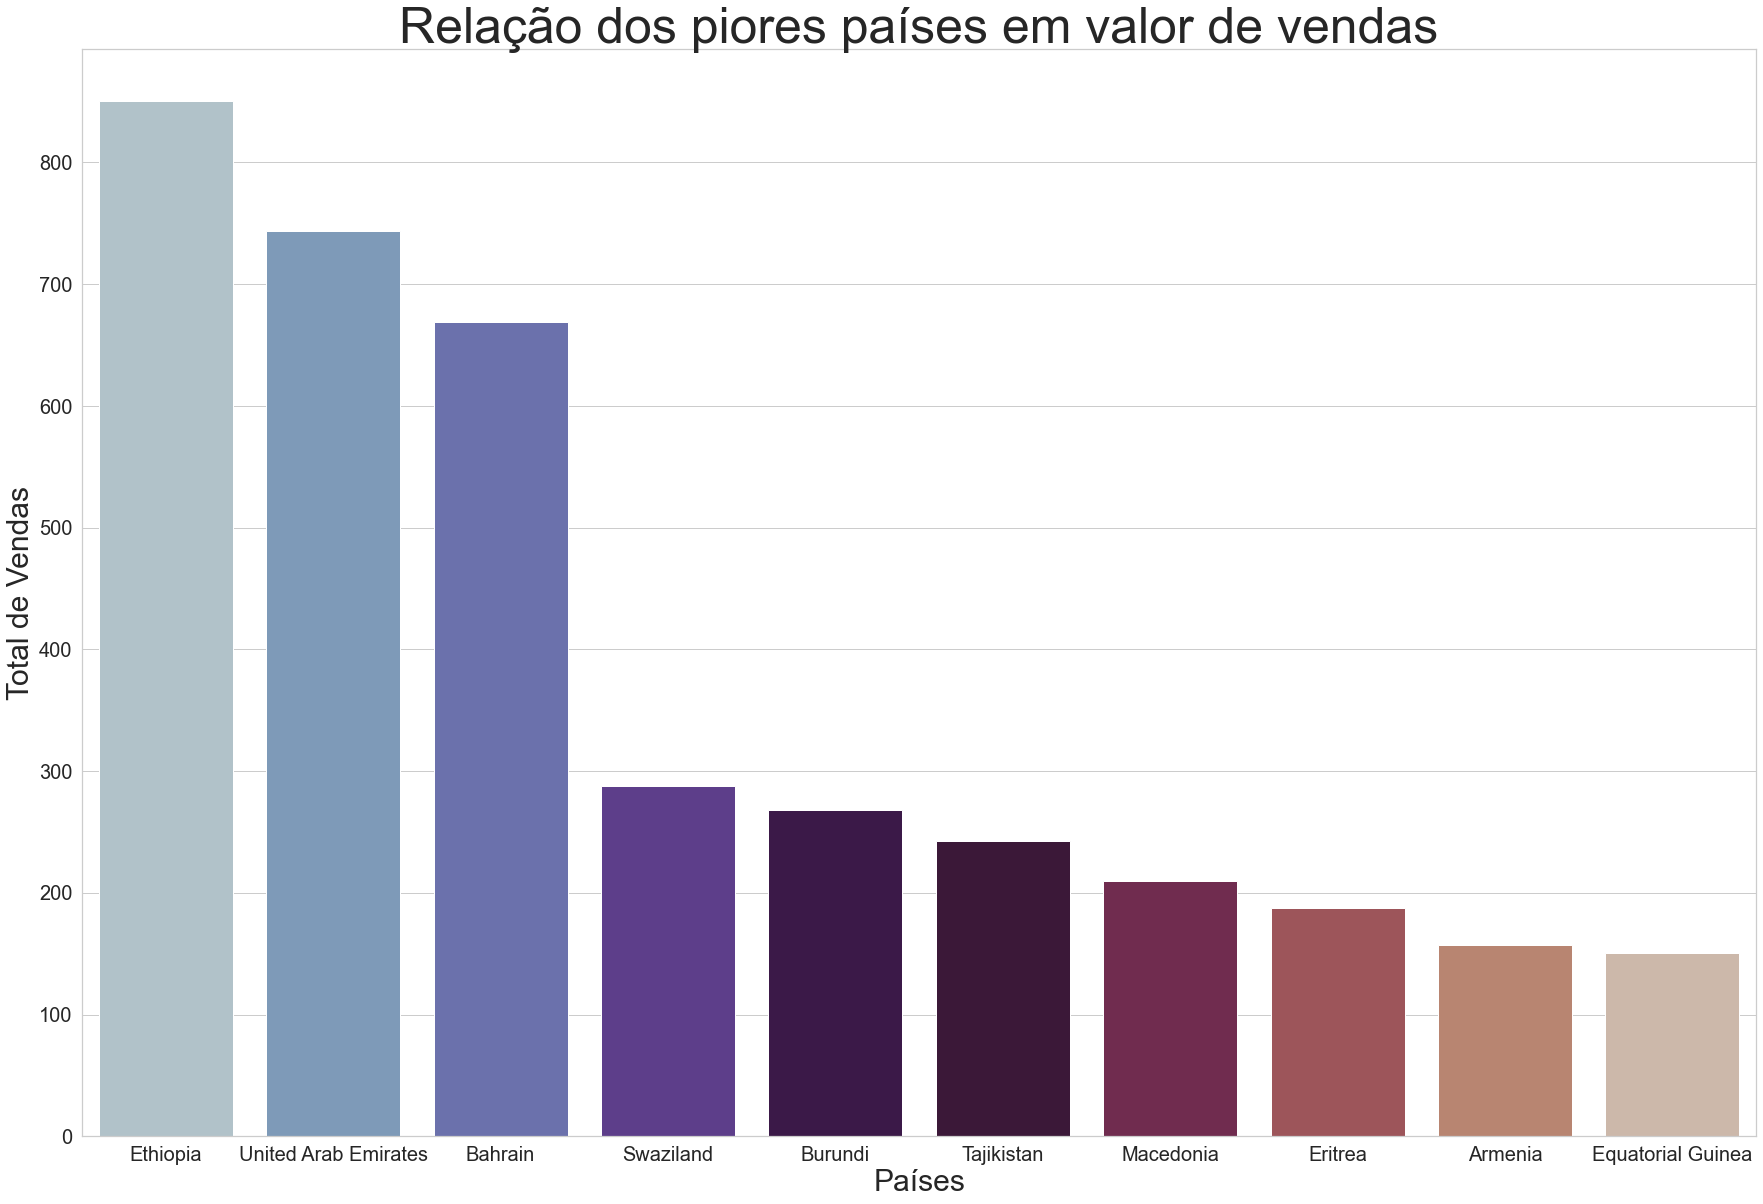

In [76]:
ax = plt.subplots(figsize=dims)
b = sns.barplot(x="country", y="sales", data=dff.sort_values(by=["sales"], ascending=False).tail(10), palette=("twilight"))
b.axes.set_title("Relação dos piores países em valor de vendas",fontsize=50)
b.set_xlabel("Países",fontsize=30)
b.set_ylabel("Total de Vendas",fontsize=30)
b.tick_params(labelsize=20)

In [77]:
data_ = df[["order_date","shipping_cost","discount","sales","quantity","profit"]]

In [78]:
data_ = data_.groupby(["order_date"])["shipping_cost","sales","discount","quantity",
                                      "profit"].sum().reset_index()
#dff = df_sales.groupby(["country"]).sales.sum().reset_index()

<ipython-input-78-7783f539b825>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_ = data_.groupby(["order_date"])["shipping_cost","sales","discount","quantity",


In [79]:
data_['order_date'] = pd.to_datetime(data_.order_date)
data_ = data_.sort_values(by="order_date")
data_

,order_date,shipping_cost,sales,discount,quantity,profit
0,2011-01-01,64.67,808.56300,0.800,19,198.87300
1,2011-01-02,342.17,2455.67000,1.350,54,603.47360
2,2011-01-03,1328.16,12565.76630,5.940,177,1905.15390
3,2011-01-04,376.49,2582.80100,6.000,86,-308.78740
4,2011-01-06,1209.56,11480.49270,5.090,154,2460.25360
...,...,...,...,...,...,...
1425,2014-12-27,1342.63,13421.26376,11.264,188,-916.64004
1426,2014-12-28,173.84,1647.17400,1.100,51,81.06380
1427,2014-12-29,2599.77,25109.28878,20.182,408,2046.20678
1428,2014-12-30,1984.04,16831.61480,12.920,284,2554.00460


### Expectativas para o próximo mês

In [ ]:
df["category"].value_counts()

Primeiramente trabalharemos com o Dataset inteiro, sem distinção entre produtos ou categorias

In [ ]:
matplotlib.rcParams['figure.figsize'] = [16, 4]

In [ ]:
df.dtypes

In [ ]:
#Relação por Quantidade
columns = df[["order_date","quantity"]]
data_ts = columns.copy()
data_ts['order_date'] = pd.to_datetime(data_ts.order_date)
data_ts = data_ts.groupby(["order_date"]).quantity.sum().reset_index()

In [ ]:
#Relação por Valor de Vendas
columns = df[["order_date","sales"]]
data_vl = columns.copy()
data_vl['order_date'] = pd.to_datetime(data_vl.order_date)
data_vl = data_vl.groupby(["order_date"]).sales.sum().reset_index()

In [ ]:
data_ts = data_ts.set_index(['order_date'])
data_vl = data_vl.set_index(['order_date'])

In [ ]:
data_ts

In [ ]:
s_ = data_ts.squeeze()
s__ = data_vl.squeeze()

idx = pd.date_range('2011-01-01', '2014-12-31')

s_ = s_.reindex(idx, fill_value=0)
s__ = s__.reindex(idx, fill_value=0)

In [ ]:
data_ts = s_.to_frame()
data_vl = s__.to_frame()

In [ ]:
data_ts.index.name = "order_date"
data_vl.index.name = "order_date"

In [ ]:
data_ts

In [ ]:
'''correlacao = data_ts['quantity'].corr(data_vl['sales'])
print("Correlação de vendas entre as duas séries: ", np.round(correlacao*100), "%" ) 
plt.scatter(data_ts['quantity'], data_vl['sales'])
plt.show()'''

In [ ]:
data_vl

In [ ]:
data_ts['quantity'].plot(grid = True, color="green")

In [ ]:
data_vl['sales'].plot(grid = True, color="red")

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].plot(data_ts.index, data_ts.quantity, color='green')
ax[0].grid()
ax[0].set_title('Quantidade de Vendas')

ax[1].plot(data_vl.index, data_vl.sales, color='red')
ax[1].grid()
ax[1].set_title('Valor total de Vendas')

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
fuller_qt = adfuller(data_ts.quantity)
fuller_ = adfuller(data_vl.sales)
print('p-valor do Teste aumentado de Dickey-Fuller para série 1: {0:.2f}'.format(np.round(fuller_qt[1],2))) 
print('p-valor do Teste aumentado de Dickey-Fuller para série 2: {0:.2f}'.format(np.round(fuller_[1],2)))

In [ ]:
data_vl.sales

In [ ]:
#test_size = 0.75
#train = data_ts.reset_index().loc[0:np.round(data_ts.shape[0] * test_size),:]
#test = data_ts.reset_index().loc[np.round(data_ts.shape[0] * test_size):,:]

train = data_ts.reset_index()
test = pd.Series(pd.date_range("2015-01-01", "2015-01-31"))
test = td.to_frame(name="order_date")
test.set_index(['order_date'])
test['quantity'] = 0


fig, ax = plt.subplots()
ax.plot(train.order_date, train.quantity, color='dimgray', label='Treino')
ax2 = ax.twinx()

ax2.plot(test.order_date, test.quantity, color='darkred',label='Validação')
plt.legend()
plt.show()

In [ ]:
test

In [ ]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
train.head()
train.index = train['order_date']

In [ ]:
data_ts.tail()

In [ ]:
model = ARMA(train.quantity, order=(6,1))

trained_model = model.fit()

print(trained_model.summary())
predict_ = trained_model.predict(start = test.order_date.min(), end = test.order_date.max())

In [ ]:
#Dados previstos para o mês de Janeiro 20115
predict_.to_frame()

In [ ]:
trained_model.plot_predict(start = train.order_date.min(), end = test.order_date.max());

fig, ax = plt.subplots()
ax.plot(train.order_date, train.quantity, color='dimgray')
ax2 = ax.twinx()
ax2.plot(test.order_date, test.quantity, color='darkred')
ax2.plot(test.order_date, predict_, color='black',label='previsão')

plt.legend()
plt.show()

In [ ]:
trained_model.resid.plot(grid = True, title  = 'Residuos/Erro')
adfuller_residuo = adfuller(trained_model.resid)
print('p-valor do Teste aumentado de Dickey-Fuller para o residuo do modelo: {0:.2f}'.format(np.round(adfuller_residuo[1],2)))